In [58]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from generator import *
from discriminator import *
from feature_extractor import *
from trainer import *
from utils import *
from metrics import *
from edgeloss import *
from torch.utils.data import DataLoader
from torchsummary import summary
from dataset import *
import torchio as tio

print(os.getcwd())
torch.cuda.empty_cache()

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

data/brain_simulated_t1w_mri/LR/23-Aug-2021_Ernst_labels_100206_3T_T1w_MPR1_img_act_1_contrast_1_Res_2_2_2_img.nii.gz


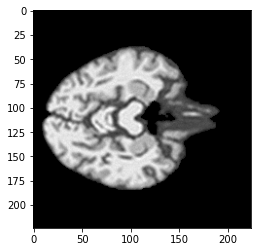

In [67]:
num = 100206
img = ImagePair(number=num, root_dir='data')
img_slice = img.img()['LR'][:,:,25]
plt.imshow(img_slice, cmap='gray')
LRf, HRf = img.LR_HR_fnames()
print(LRf)

(1, 224, 224, 69)


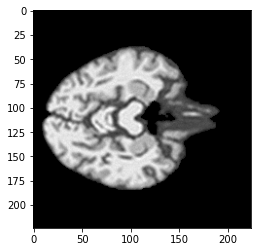

In [68]:
img_np = np.expand_dims(img.img()['LR'],0)
print(img_np.shape)
subject_a = tio.Subject(
    lr=tio.ScalarImage(tensor=torch.from_numpy(img_np)),
    # hr=tio.ScalarImage(HRf),
)
plt.imshow(subject_a['lr'].numpy()[0,:,:,25], cmap='gray')

In [6]:

print(subject_a.shape)
sampler = tio.GridSampler(subject=subject_a, patch_size=(64,64,1), patch_overlap=(32, 32, 0), padding_mode='symmetric')
print(len(sampler))

(1, 224, 224, 69)
0.00677943229675293
2484


(1, 64, 64, 1)


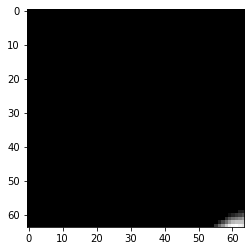

In [7]:
print(sampler[0]['lr'].numpy().shape)
plt.imshow(np.squeeze(sampler[15]['lr'].numpy()), cmap='gray')


In [18]:
def MakePatchStartArray(patchSize = np.array([64,64]), ovlPerc = np.array([0.5, 0.5])):
    # size03D  = (np.array(image.shape)).astype(np.int)
    size03D  = [230, 230, 70]
    # show the X and Y sizes
    size0    = np.array([size03D[0], size03D[1]])
    # the third part of size03D shows the amount of slices in the image (Z direction)
    nrSlices = size03D[2]
    # define the amount of patches which need to be made, keep in mind the overlap of the patches (this is in X and in Y)
    numberOfPatches = (np.divide(size0, (ovlPerc * patchSize))).astype(int) - 1
    # define the image size which will be the output when setting all patches back to an image
    roundedFull = patchSize + (numberOfPatches - 1) * ovlPerc * patchSize
    # empty space that remains after dividing images in patches
    residual    = size0 - roundedFull
    # difference between each patch (in space) to divide the patches over the image equally
    deltaPix    = np.divide(residual, (numberOfPatches - 1))
    # start an empty list to add the start arrays of the X direction to
    startArrayY = []
    # start an empty list to add the start arrays of the Y direction to
    startArrayX = []
    # loop over the amount of patches needed in the X direction
    for x in range(numberOfPatches[0]):
        # define the startpoint for every slice in X direction
        startArrayX.append(int(ovlPerc[0] * patchSize[0] * x + deltaPix[0] * x + 0.5))
    # loop over the amount of patches needed in the Y direction
    for y in range(numberOfPatches[1]):
        # define the startpoint for every slice in Y direction
        startArrayY.append(int(ovlPerc[1] * patchSize[1] * y + deltaPix[1] * y + 0.5))
    # return the start position of X and Y, the amount of patches in the slice and the
    # number of slices in the image when the method is called
    return startArrayX,startArrayY,numberOfPatches,nrSlices,size03D,size0

In [19]:
startArrayX,startArrayY,numberOfPatches,nrSlices,size03D,size0 = MakePatchStartArray()

print(startArrayX)
print(startArrayX)
print(numberOfPatches)
print(nrSlices)
print(size03D)
print(size0)


[0, 33, 66, 100, 133, 166]
[0, 33, 66, 100, 133, 166]
[6 6]
70
[230, 230, 70]
[230 230]


In [80]:
size03D = [224,224,70]
ovl_perc = [.5, .5]
patch = [64,64]
nr_patches = (np.divide(np.array([size03D[0], size03D[1]]),
                        (np.array(ovl_perc) * np.array(patch)))).astype(int) - 1
roundedFull = np.array(patch) + (nr_patches-1) * np.array(ovl_perc) * np.array(patch)
residual    = np.array([size03D[0], size03D[1]]) - roundedFull
deltaPix    = np.ceil(np.divide(residual, nr_patches))
overlap     = np.array(patch) * np.array(ovl_perc) + deltaPix

# residual = (size[0]-nr_patches*patch[0]*ovl_perc)
# deltaPix = residual/nr_patches
# overlap = patch[0]*ovl_perc+deltaPix
# print(size[:1])
print(nr_patches)
print(roundedFull)
print(residual)
print(deltaPix)
print(overlap)

[6 6]
[224. 224.]
[0. 0.]
[0. 0.]
[32. 32.]


In [57]:
a = np.array([1,2,3,4,5])
print(np.pad(a, 6, mode='symmetric'))


[5 5 4 3 2 1 1 2 3 4 5 5 4 3 2 1 1]
